In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# data set
import torchvision.datasets as dset

# image transform kit
import torchvision.transforms as transforms

# 전처리가 끝난 데이터를 지정한 배치 크기에 맞게 모아서 전달하는 역할
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [0]:
torch.Tensor([1, 2]).type()

'torch.FloatTensor'

## hyper parameter

In [0]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

## data download

In [0]:
# root = data save location
# train = 학습용 데이터면 true 아니면 False(True = Train, False = Test)

# trainsfrom = 이미지 변형
# target_fransform = 정답 라벨에 대한 변형
# transform_ToTensor = PIL image or Numpy arrange를 torch Tensor로 바꿔줌
# download = 현재 경로에 데이터가 없을 경우 추가로 다운도 받을지 여부
mnist_train = dset.MNIST(root="./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(root="./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

0it [00:00, ?it/s]

9920512it [00:07, 1291121.44it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 57569.43it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 1073318.41it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 21852.17it/s]            


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


## DataSet Check

In [0]:
mnist_train.__getitem__

<bound method MNIST.__getitem__ of Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()>

In [0]:
mnist_train.__getitem__(0)[0].size(), len(mnist_train)
mnist_train.__getitem__(0)[0].size(), len(mnist_train)

(torch.Size([1, 28, 28]), 60000)

In [0]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

## DataSet settings

In [0]:
# 데이터 증강
'''mnist_train = dset.MNIST("./", train=True, 
                         transform = transforms.Compose([
                             transforms.Resize(34),                             # 원래 28x28인 이미지를 34x34로 늘립니다.
                             transforms.CenterCrop(28),                         # 중앙 28x28를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),                 # 랜덤하게 좌우반전 합니다.
                             transforms.Lambda(lambda x: x.rotate(90)),         # 람다함수를 이용해 90도 회전해줍니다.
                             transforms.ToTensor(),                             # 이미지를 텐서로 변형합니다.
                         ]),
                         target_transform=None,
                         download=True)'''

# data trainform
'''transfroms.Compose([
                    transforms.Normalize(mean=(0.1307,), std=(0.3081,))])
                    를 넣어주면 됨, RGB면
                    mean = (0.1307, 0.1364, 0.1354), std도 3개'''

In [0]:
# batch_size = 256
# 배치사이즈 정해주고 섞고 사용할 프로세스 갯수 적고 마지막 남는
# 데이터 처리 여부(True면 배치 단위로 안 끊어지는 마지막 데이터 삭제)
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, 
                          num_workers = 2, drop_last = True)
test_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = False, 
                          num_workers = 2, drop_last = True)

In [0]:
# 오버피팅이 되지 않은 상태에서 L2나 dropout하면 성능이 더 떨어짐
class CNN(nn.Module):
  def __init__(self):
    # super는 CNN 클래스의 부모 클래스인 nn.Module을 초기화
    super(CNN, self).__init__()
    self.layer = nn.Sequential(
        # 1, 28, 28 -> 16, 28, 28
        nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5),
        nn.ReLU(),
        # 16, 24, 24 -> 32, 20, 20
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5),
        nn.ReLU(),
        #nn.Dropout2d(0.2),
        # 32, 20, 20 -> 32, 10, 10
        nn.MaxPool2d(kernel_size = 2, stride = 2),
        # 32, 10, 10 -> 64, 6, 6
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5),
        nn.ReLU(),
        # 64, 3, 3
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

# batch norm
'''
nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.BatchNorm2d(64),
    이런 식으로 합성곱층 위의 out_channels과 똑같이 해주면 됨'''
    
    self.fc_layer = nn.Sequential(
        nn.Linear(64 * 3 * 3, 100), # 64 * 3 * 3 -> 100
        nn.ReLU(),
           nn.Linear(100, 10) # 100 -> 10
    )

    # W initialization
'''for m in self.modules():
            # 만약 그 모듈이 nn.Conv2d인 경우
            if isinstance(m, nn.Conv2d):
                
                # 작은 숫자로 초기화하는 방법
                # 가중치를 평균 0, 편차 0.02로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
                
                # Xavier Initialization
                # 모듈의 가중치를 xavier normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)
                
                
                # Kaming Initialization
                # 모듈의 가중치를 kaming he normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            
            # 만약 그 모듈이 nn.Linear인 경우
            elif isinstance(m, nn.Linear):
                
                # 작은 숫자로 초기화하는 방법
                # 가중치를 평균 0, 편차 0.02로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0)
                
                # Xavier Initialization
                # 모듈의 가중치를 xavier normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.xavier_normal(m.weight.data)
                m.bias.data.fill_(0)
                
                
                # Kaming Initialization
                # 모듈의 가중치를 kaming he normal로 초기화합니다.
                # 편차를 0으로 초기화합니다.
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)'''

  def forward(self, x):
    out = self.layer(x) # Sequential 연산 차례대로 실행
    out = out.view(batch_size , -1) # 텐서를 batch_size, 나머지로 바꿔줌

    out = self.fc_layer(out)
    return out

## loss & minimize

In [0]:
# gpu가 사용가능하면 device를 gpu로, 아니면 cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# 모델을 지정한 장치로 올림
model = CNN().to(device)

# 손실함수는 crossentropy
loss_func = nn.CrossEntropyLoss()

# 최적화는 adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# L2
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.1)

'''# 지정한 스텝 단위로 학습률에 감마를 곱해 학습률을 감소시킵니다.
#scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma= 0.99)       

# 지정한 스텝 지점(예시에서는 10,30,80)마다 학습률에 감마를 곱해줍니다.
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10,30,80], gamma= 0.1)  

# 매 epoch마다 학습률에 감마를 곱해줍니다.
#scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)                             

# https://pytorch.org/docs/stable/optim.html?highlight=lr_scheduler#torch.optim.lr_scheduler.ReduceLROnPlateau
# 지정한 메트릭으로 측정한 값이 더 나아지지 않으면 학습률을 감소시킵니다. ex) 정확도, dice score 등등
# 이 스케쥴러에는 다양한 인자가 들어가는데 각각의 역할은 도큐먼트를 참고 바랍니다.
# 여기서는 patience 즉, 지정한 값이 줄어들지 않을때 몇 epoch 만큼을 지켜볼 것인지를 1로 낮춰놨기 때문에 매 epoch 마다 학습률이 감소하는것을 확인할 수 있습니다.
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,threshold=1,patience=1,mode='min')    

# 참고 https://www.geeksforgeeks.org/python-dir-function/
print(dir(scheduler))
print(dir(optimizer))'''

cuda:0


## training

In [0]:
loss_arr = []
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader):
    x = image.to(device)
    y = label.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, y)
    loss.backward()
    optimizer.step()
    if j % 1000 == 0:
      print(loss)
      loss_arr.append(loss.cpu().detach().numpy())

    '''
    # ReduceLRONPlateau 만 해당됩니다. 이 코드에서는 손실이 줄어들지 않으면 학습률을 낮추도록 만들어놨습니다.
    scheduler.step(loss)
    '''

tensor(0.0077, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0523, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0453, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0192, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0246, device='cuda:0', grad_fn=<NllLossBackward>)


## training loss visualization

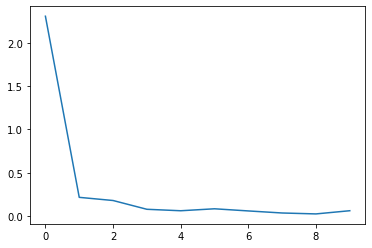

In [0]:
plt.plot(loss_arr)
plt.show()

## test data acc

In [0]:
# 맞은 갯수, 전체 개수를 저장할 변수를 지정
correct=  0
total = 0

# batch norm나 드롭아웃을 썼다면 모델을 eval모드로 바꿔야 함.
# model.train() # batch norm, dropout을 사용할 때
# model.eval() # batch norm, dropout을 사용하고 실제 예측할 때

# inference model
with torch.no_grad():
  # 테스트 로더에서 이미지와 정답을 불러옴
  for image, label in test_loader:

    # 두 데이터 모두 장치에 올림
    x = image.to(device)
    y = label.to(device)

    # 모델에 데이터를 넣고 결과값을 얻음
    output = model.forward(x)

    # torch.max로 최대값과 최대값 인덱스를 뽑아냄
    # 최대값은 필요없어서 인덱스만 사용
    _, output_index = torch.max(output, 1)

    # 전체 개수는 라벨의 개수로 더해줌
    total += label.size(0) # == label.size[0]  아까 drop last로 짤렸을 수도 있어서

    # 모델 결과의 최대값 인덱스와 라벨이 일치하는 개수를 correct에 더해줌
    correct += (output_index == y).sum().float()

  print('acc: {}%'.format(100 * correct / total))

acc: 98.81978607177734%


In [0]:
torch.max(torch.Tensor([[1, 2],
                        [3, 4]]), 1) # 1이니까 -> 이쪽 방향

torch.return_types.max(values=tensor([3., 4.]), indices=tensor([1, 1]))